In [ ]:
# ============================================================
# - IMDb Sentiment — Legacy-safe transformers (best model via callback)
# - Works on older transformers (no evaluation_strategy/save_strategy/etc.)
# - Saves model-only (no optimizer.pt) when metric improves
# ============================================================

<h1> Step 0: Global toggles / env </h1>


In [ ]:
import os
# Disable Weights & Biases prompts; harmless if wandb isn't installed.
os.environ["WANDB_DISABLED"] = "true"

<h1> Step 1: Setup and Installation </h1>

In [ ]:
%pip install -q transformers datasets evaluate scikit-learn pandas numpy matplotlib seaborn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00


<h1> Step 2: Import Libraries and Setup </h1>

In [ ]:
from google.colab import drive
import os, random, gc, glob, shutil
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
from torch.utils.data import Dataset
from datasets import load_dataset
import evaluate

from transformers import (
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    BertTokenizer, BertForSequenceClassification,
    DistilBertTokenizer, DistilBertForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification,
    TrainerCallback,
)

import warnings
warnings.filterwarnings("ignore")

# Reproducibility and device
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(42)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# Small perf boost if GPU supports TF32 (harmless if not available)
try:
    if torch.cuda.is_available():
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
except Exception:
    pass

Device: cpu


<h1> Step 3: Mount Drive & make folder tree </h1>

In [ ]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# BASE_DIR = "/content/drive/MyDrive/bert_imdb_sentiment_analysis"
# RAW_DATA_DIR = os.path.join(BASE_DIR, "raw_data")
# PROCESSED_DATA_DIR = os.path.join(BASE_DIR, "processed_data")
# MODELS_DIR = os.path.join(BASE_DIR, "models")
# RESULTS_DIR = os.path.join(BASE_DIR, "results")
# COMPARISON_DIR = os.path.join(BASE_DIR, "model_comparison")

# for d in [BASE_DIR, RAW_DATA_DIR, PROCESSED_DATA_DIR, MODELS_DIR, RESULTS_DIR, COMPARISON_DIR]:
#     os.makedirs(d, exist_ok=True)
#     print("Created/Verified:", d)

Created new: /content/drive/MyDrive/bert_imdb_sentiment_analysis
Created new: /content/drive/MyDrive/bert_imdb_sentiment_analysis/raw_data
Created new: /content/drive/MyDrive/bert_imdb_sentiment_analysis/processed_data
Created new: /content/drive/MyDrive/bert_imdb_sentiment_analysis/models
Created new: /content/drive/MyDrive/bert_imdb_sentiment_analysis/results
Created new: /content/drive/MyDrive/bert_imdb_sentiment_analysis/model_comparison


<h1> Step 4: Load IMDb (cache to/reuse from Drive) </h1>

In [ ]:
def download_imdb_dataset() -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Download IMDb from 🤗 datasets and persist raw CSVs in Drive.
    """
    print("Downloading IMDb…")
    ds = load_dataset("imdb")
    train_df = ds["train"].to_pandas()
    test_df  = ds["test"].to_pandas()
    train_df.to_csv(os.path.join(RAW_DATA_DIR, "imdb_train.csv"), index=False)
    test_df.to_csv(os.path.join(RAW_DATA_DIR, "imdb_test.csv"),  index=False)
    print(f"IMDb: {len(train_df)} train / {len(test_df)} test")
    return train_df, test_df

train_path = os.path.join(RAW_DATA_DIR, "imdb_train.csv")
test_path  = os.path.join(RAW_DATA_DIR, "imdb_test.csv")

if os.path.exists(train_path) and os.path.exists(test_path):
    print("Loading IMDb from Drive cache…")
    train_df = pd.read_csv(train_path)
    test_df  = pd.read_csv(test_path)
else:
    train_df, test_df = download_imdb_dataset()

# Stratified validation split and persist processed splits
train_df, val_df = train_test_split(
    train_df, test_size=0.1, random_state=42, stratify=train_df["label"]
)
print(f"Splits -> Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

train_df.to_csv(os.path.join(PROCESSED_DATA_DIR, "train_split.csv"), index=False)
val_df.to_csv(os.path.join(PROCESSED_DATA_DIR,   "val_split.csv"),   index=False)
test_df.to_csv(os.path.join(PROCESSED_DATA_DIR,  "test_split.csv"),  index=False)


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

IMDb: 25000 train / 25000 test
Splits -> Train: 22500, Val: 2500, Test: 25000


<h1> Step 5: Tokenization helper + Dataset wrapper </h1>

In [ ]:
def tokenize_texts(tokenizer, texts: List[str], max_length: int):
    """
    Tokenize without padding; dynamic padding will be applied by the data collator.
    """
    return tokenizer(texts, truncation=True, padding=False, max_length=max_length)

class IMDbDataset(Dataset):
    """
    Thin PyTorch dataset wrapping tokenized encodings and labels.
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(int(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.labels)

<h1> Step 6: Metrics (backward-compatible) </h1>

In [ ]:
acc_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    """
    Compute accuracy and weighted F1.

    Compatible with:
      - older transformers: eval_pred is (logits, labels) tuple
      - newer transformers: eval_pred has .predictions / .label_ids
    """
    try:
        logits = getattr(eval_pred, "predictions", None)
        labels = getattr(eval_pred, "label_ids", None)
        if logits is None or labels is None:
            raise AttributeError
    except AttributeError:
        logits, labels = eval_pred

    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": acc_metric.compute(predictions=preds, references=labels)["accuracy"],
        "f1_weighted": f1_score(labels, preds, average="weighted"),
    }


<h1> Step 7: Model registry (use shorter seq len to reduce RAM) </h1>

In [ ]:
BERT_MODELS: Dict[str, Dict] = {
    "bert-base-uncased": {
        "name": "BERT Base Uncased",
        "tokenizer": BertTokenizer,
        "model": BertForSequenceClassification,
        "max_length": 256,
    },
    "distilbert-base-uncased": {
        "name": "DistilBERT Base Uncased",
        "tokenizer": DistilBertTokenizer,
        "model": DistilBertForSequenceClassification,
        "max_length": 256,
    },
    "roberta-base": {
        "name": "RoBERTa Base",
        "tokenizer": RobertaTokenizer,
        "model": RobertaForSequenceClassification,
        "max_length": 256,
    },
    # You can add more backbones if you have space/time.
}

print("\nModels selected:")
for m, cfg in BERT_MODELS.items():
    print(f" - {cfg['name']} ({m})")


Models selected:
 - BERT Base Uncased (bert-base-uncased)
 - DistilBERT Base Uncased (distilbert-base-uncased)
 - RoBERTa Base (roberta-base)


<h1>  Step 8: Prepare datasets per model </h1>

In [ ]:
from transformers import AutoTokenizer
def prepare_datasets_for_model(
    model_id: str, cfg: Dict,
    train_texts, val_texts, test_texts,
    train_labels, val_labels, test_labels
):
    """
    Build tokenizer, tokenized encodings and Dataset objects for a given model.
    Falls back if `use_fast` isn't supported by older transformers builds.
    """
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
    except TypeError:
        tokenizer = AutoTokenizer.from_pretrained(model_id)

    max_len = cfg["max_length"]
    train_enc = tokenize_texts(tokenizer, train_texts.tolist(), max_len)
    val_enc   = tokenize_texts(tokenizer, val_texts.tolist(),   max_len)
    test_enc  = tokenize_texts(tokenizer, test_texts.tolist(),  max_len)

    return (
        tokenizer,
        IMDbDataset(train_enc, train_labels),
        IMDbDataset(val_enc,   val_labels),
        IMDbDataset(test_enc,  test_labels),
    )

<h1> Step 9: Trainer override to avoid any internal checkpointing </h1>

In [ ]:
class LightweightTrainer(Trainer):
    """
    Overrides Trainer's internal checkpoint saving so it never writes
    optimizer.pt / scheduler.pt / trainer_state.json.
    We will save ONLY the best model (weights+tokenizer) via callback.
    """
    def _save_checkpoint(self, model, trial, metrics=None):
        return  # no-op

    def _sorted_checkpoints(self, output_dir=None, checkpoint_prefix="checkpoint", use_mtime=False):
        return []  # pretend there are none

    # Some versions call save_model() internally; make it a no-op here.
    def save_model(self, output_dir=None, _internal_call=False):
        return


<h1> Step 10: Build trainer (legacy-safe args) - </h1>

In [ ]:
def build_trainer(
    model,
    tokenizer,
    train_dataset,
    val_dataset,
    output_dir: str,
    epochs: int = 3,
    lr: float = 2e-5,
    batch_train: int = 8,
    batch_eval: int = 8,
) -> Trainer:
    """
    Create a Trainer that:
      - Works on old transformers (no modern-only args)
      - Uses dynamic padding
      - Aggressively disables internal checkpointing
    """
    # Dynamic padding collator (fallback if missing)
    try:
        from transformers import DataCollatorWithPadding
        collator = DataCollatorWithPadding(tokenizer=tokenizer)
    except Exception:
        from transformers import default_data_collator
        collator = default_data_collator

    # Build TrainingArguments with "suppress saves" where possible
    args_kwargs = dict(
        output_dir=output_dir,
        per_device_train_batch_size=batch_train,
        per_device_eval_batch_size=batch_eval,
        learning_rate=lr,
        num_train_epochs=epochs,
        weight_decay=0.01,
        logging_dir=os.path.join(output_dir, "logs"),
        dataloader_pin_memory=True,
    )
    for k, v in [
        ("save_steps", 10**12),           # essentially "never"
        ("save_strategy", "no"),          # newer transformers only
        ("load_best_model_at_end", False),
        ("report_to", []),
    ]:
        try:
            args_kwargs[k] = v
        except Exception:
            pass

    training_args = TrainingArguments(**args_kwargs)

    return LightweightTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,   # so trainer.evaluate() works
        tokenizer=tokenizer,
        data_collator=collator,
        compute_metrics=compute_metrics,
    )

<h1> Step 11: Callbacks (Best-saver + Janitor) </h1>

In [ ]:
class BestModelSaverCallback(TrainerCallback):
    """
    At each epoch end:
      - Evaluate on the attached eval_dataset
      - If eval_f1_weighted improves, save MODEL-ONLY to best_model/
    """
    def __init__(self, trainer_ref, metric_name="f1_weighted", greater_is_better=True):
        self.trainer_ref = trainer_ref
        self.metric_name = metric_name
        self.greater_is_better = greater_is_better
        self.best = -np.inf if greater_is_better else np.inf

    def on_epoch_end(self, args, state, control, **kwargs):
        metrics = self.trainer_ref.evaluate(self.trainer_ref.eval_dataset)
        key = f"eval_{self.metric_name}"
        score = metrics.get(key, None)
        if score is None:
            print(f"[BestModelSaver] Missing metric '{key}'. Available:", list(metrics.keys()))
            return control
        improved = (score > self.best) if self.greater_is_better else (score < self.best)
        if improved:
            self.best = score
            best_dir = os.path.join(args.output_dir, "best_model")
            os.makedirs(best_dir, exist_ok=True)
            self.trainer_ref.model.save_pretrained(best_dir, safe_serialization=True)
            self.trainer_ref.tokenizer.save_pretrained(best_dir)
            print(f"[BestModelSaver] New best {self.metric_name}: {score:.6f}. Saved to: {best_dir}")
        return control

class CheckpointJanitorCallback(TrainerCallback):
    """
    Deletes large training-state files as soon as they appear so Drive doesn't fill up.
    Removes: optimizer.pt, scheduler.pt, scaler.pt, trainer_state.json
    Optionally removes entire 'checkpoint-*' directories.
    """
    def __init__(self, remove_checkpoint_dirs: bool = True):
        self.remove_checkpoint_dirs = remove_checkpoint_dirs

    def _sweep(self, output_dir: str):
        if not os.path.isdir(output_dir):
            return
        patterns = [
            "**/optimizer.pt",
            "**/scheduler.pt",
            "**/scaler.pt",
            "**/trainer_state.json",
        ]
        deleted = 0
        for pat in patterns:
            for f in glob.glob(os.path.join(output_dir, pat), recursive=True):
                try:
                    os.remove(f)
                    deleted += 1
                except Exception:
                    pass

        if self.remove_checkpoint_dirs:
            for ckpt in glob.glob(os.path.join(output_dir, "checkpoint-*")):
                shutil.rmtree(ckpt, ignore_errors=True)

        if deleted > 0:
            print(f"[Janitor] Deleted {deleted} training-state files under: {output_dir}")

    # Trigger on saves (newer TF) and epoch end (legacy)
    def on_save(self, args, state, control, **kwargs):
        self._sweep(args.output_dir); return control

    def on_epoch_end(self, args, state, control, **kwargs):
        self._sweep(args.output_dir); return control

    # Also sweep periodically by steps (lightweight)
    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step and state.global_step % 100 == 0:
            self._sweep(args.output_dir)
        return control

<h1> Step 12: Train & evaluate loop </h1>

In [ ]:
results = {}

train_texts = train_df["text"];  val_texts = val_df["text"];  test_texts = test_df["text"]
train_labels = train_df["label"].values
val_labels   = val_df["label"].values
test_labels  = test_df["label"].values

for model_id, cfg in BERT_MODELS.items():
    print("\n" + "="*72)
    print(f"PROCESSING: {cfg['name']} ({model_id})")
    print("="*72)

    out_dir = os.path.join(MODELS_DIR, model_id.replace("/", "_"))
    os.makedirs(out_dir, exist_ok=True)

    # Tokenizer & datasets
    tokenizer, train_ds, val_ds, test_ds = prepare_datasets_for_model(
        model_id, cfg,
        train_texts, val_texts, test_texts,
        train_labels, val_labels, test_labels
    )

    # Model
    model = cfg["model"].from_pretrained(
        model_id,
        num_labels=2,
        id2label={0: "NEGATIVE", 1: "POSITIVE"},
        label2id={"NEGATIVE": 0, "POSITIVE": 1},
    ).to(DEVICE)

    # Optional: reduce memory
    try: model.gradient_checkpointing_enable()
    except Exception: pass

    # Trainer
    trainer = build_trainer(
        model=model,
        tokenizer=tokenizer,
        train_dataset=train_ds,
        val_dataset=val_ds,
        output_dir=out_dir,
        epochs=3,           # adjust as desired
        lr=2e-5,
        batch_train=8,      # keep conservative for Colab RAM
        batch_eval=8,
    )

    # Callbacks: best-saver + janitor
    trainer.add_callback(BestModelSaverCallback(trainer, metric_name="f1_weighted", greater_is_better=True))
    trainer.add_callback(CheckpointJanitorCallback(remove_checkpoint_dirs=True))

    # Train
    trainer.train()

    # Final sweep just in case
    CheckpointJanitorCallback(remove_checkpoint_dirs=True)._sweep(out_dir)

    # Best model location (model-only)
    best_dir = os.path.join(out_dir, "best_model")
    print("Best model (model-only) saved at:", best_dir)

    # Evaluate on test set
    test_metrics = trainer.evaluate(test_ds)
    results[model_id] = {
        "model_name": cfg["name"],
        "eval_accuracy": float(test_metrics.get("eval_accuracy", float("nan"))),
        "eval_f1_weighted": float(test_metrics.get("eval_f1_weighted", float("nan"))),
        "eval_loss": float(test_metrics.get("eval_loss", float("nan"))),
        "model_size": int(sum(p.numel() for p in model.parameters())),
    }
    print(f"Test -> Acc: {results[model_id]['eval_accuracy']:.4f} | F1(w): {results[model_id]['eval_f1_weighted']:.4f}")

    # Free VRAM/RAM before next backbone
    del trainer, model, tokenizer, train_ds, val_ds, test_ds
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()



PROCESSING: BERT Base Uncased (bert-base-uncased)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


[BestModelSaver] New best f1_weighted: 0.903814. Saved to: /content/drive/MyDrive/bert_imdb_sentiment_analysis/models/bert-base-uncased/best_model


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


[BestModelSaver] New best f1_weighted: 0.920399. Saved to: /content/drive/MyDrive/bert_imdb_sentiment_analysis/models/bert-base-uncased/best_model


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


[BestModelSaver] New best f1_weighted: 0.920800. Saved to: /content/drive/MyDrive/bert_imdb_sentiment_analysis/models/bert-base-uncased/best_model
Best model (model-only) saved at: /content/drive/MyDrive/bert_imdb_sentiment_analysis/models/bert-base-uncased/best_model


Test -> Acc: 0.9219 | F1(w): 0.9219

PROCESSING: DistilBERT Base Uncased (distilbert-base-uncased)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


[BestModelSaver] New best f1_weighted: 0.888904. Saved to: /content/drive/MyDrive/bert_imdb_sentiment_analysis/models/distilbert-base-uncased/best_model


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


[BestModelSaver] New best f1_weighted: 0.908761. Saved to: /content/drive/MyDrive/bert_imdb_sentiment_analysis/models/distilbert-base-uncased/best_model


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


[BestModelSaver] New best f1_weighted: 0.912397. Saved to: /content/drive/MyDrive/bert_imdb_sentiment_analysis/models/distilbert-base-uncased/best_model
Best model (model-only) saved at: /content/drive/MyDrive/bert_imdb_sentiment_analysis/models/distilbert-base-uncased/best_model


Test -> Acc: 0.9112 | F1(w): 0.9112

PROCESSING: RoBERTa Base (roberta-base)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


[BestModelSaver] New best f1_weighted: 0.919165. Saved to: /content/drive/MyDrive/bert_imdb_sentiment_analysis/models/roberta-base/best_model


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


[BestModelSaver] New best f1_weighted: 0.927992. Saved to: /content/drive/MyDrive/bert_imdb_sentiment_analysis/models/roberta-base/best_model
Best model (model-only) saved at: /content/drive/MyDrive/bert_imdb_sentiment_analysis/models/roberta-base/best_model


Test -> Acc: 0.9353 | F1(w): 0.9353


<h1> Step 13: Results & plot </h1>


=== MODEL PERFORMANCE COMPARISON ===
                                      model_name  eval_accuracy  \
roberta-base                        RoBERTa Base        0.93528   
bert-base-uncased              BERT Base Uncased        0.92188   
distilbert-base-uncased  DistilBERT Base Uncased        0.91116   

                         eval_f1_weighted  eval_loss  model_size  
roberta-base                     0.935278   0.349450   124647170  
bert-base-uncased                0.921879   0.396506   109483778  
distilbert-base-uncased          0.911159   0.423456    66955010  


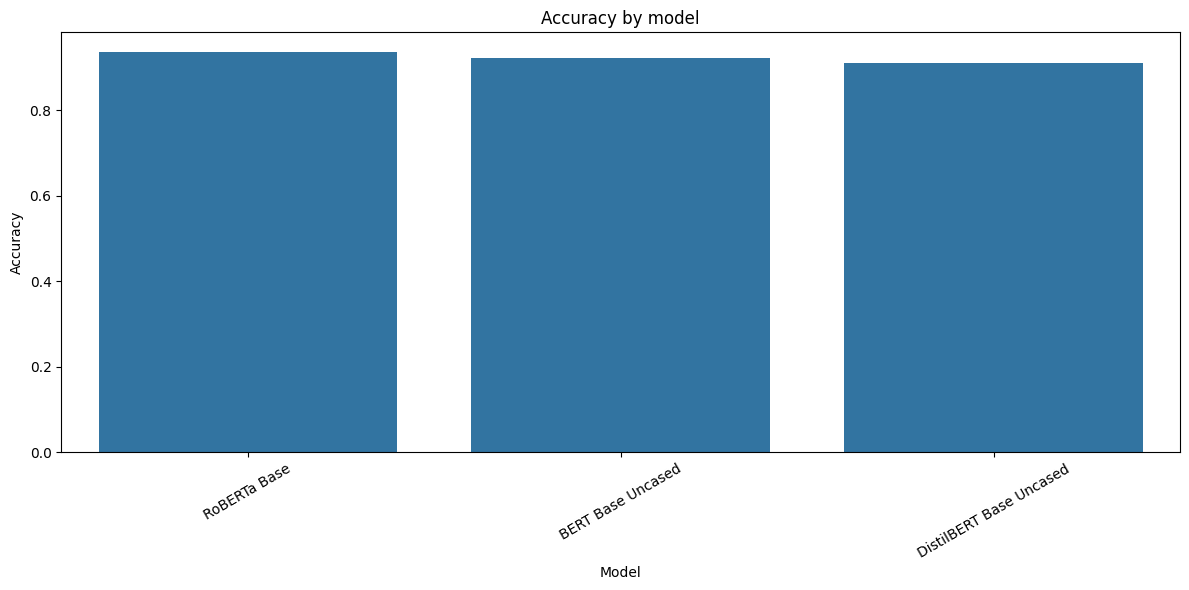


 Training complete. Best snapshots live at: .../models/<model_id>/best_model/


In [ ]:
results_df = pd.DataFrame.from_dict(results, orient='index').sort_values('eval_accuracy', ascending=False)
results_df.to_csv(os.path.join(COMPARISON_DIR, 'model_comparison_results.csv'))

print("\n=== MODEL PERFORMANCE COMPARISON ===")
print(results_df[["model_name","eval_accuracy","eval_f1_weighted","eval_loss","model_size"]])

plt.figure(figsize=(12,6))
sns.barplot(x=results_df.reset_index()["model_name"], y=results_df.reset_index()["eval_accuracy"])
plt.title("Accuracy by model"); plt.ylabel("Accuracy"); plt.xlabel("Model"); plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig(os.path.join(COMPARISON_DIR,'model_comparison.png'), dpi=300)
plt.show()

print("\n Training complete. Best snapshots live at: .../models/<model_id>/best_model/")

<h1> Results table + 2×2 comparison dashboard </h1>


=== MODEL PERFORMANCE COMPARISON ===
                                      model_name  eval_accuracy  \
roberta-base                        RoBERTa Base        0.93528   
bert-base-uncased              BERT Base Uncased        0.92188   
distilbert-base-uncased  DistilBERT Base Uncased        0.91116   

                         eval_f1_weighted  eval_loss  model_size  
roberta-base                     0.935278   0.349450   124647170  
bert-base-uncased                0.921879   0.396506   109483778  
distilbert-base-uncased          0.911159   0.423456    66955010  


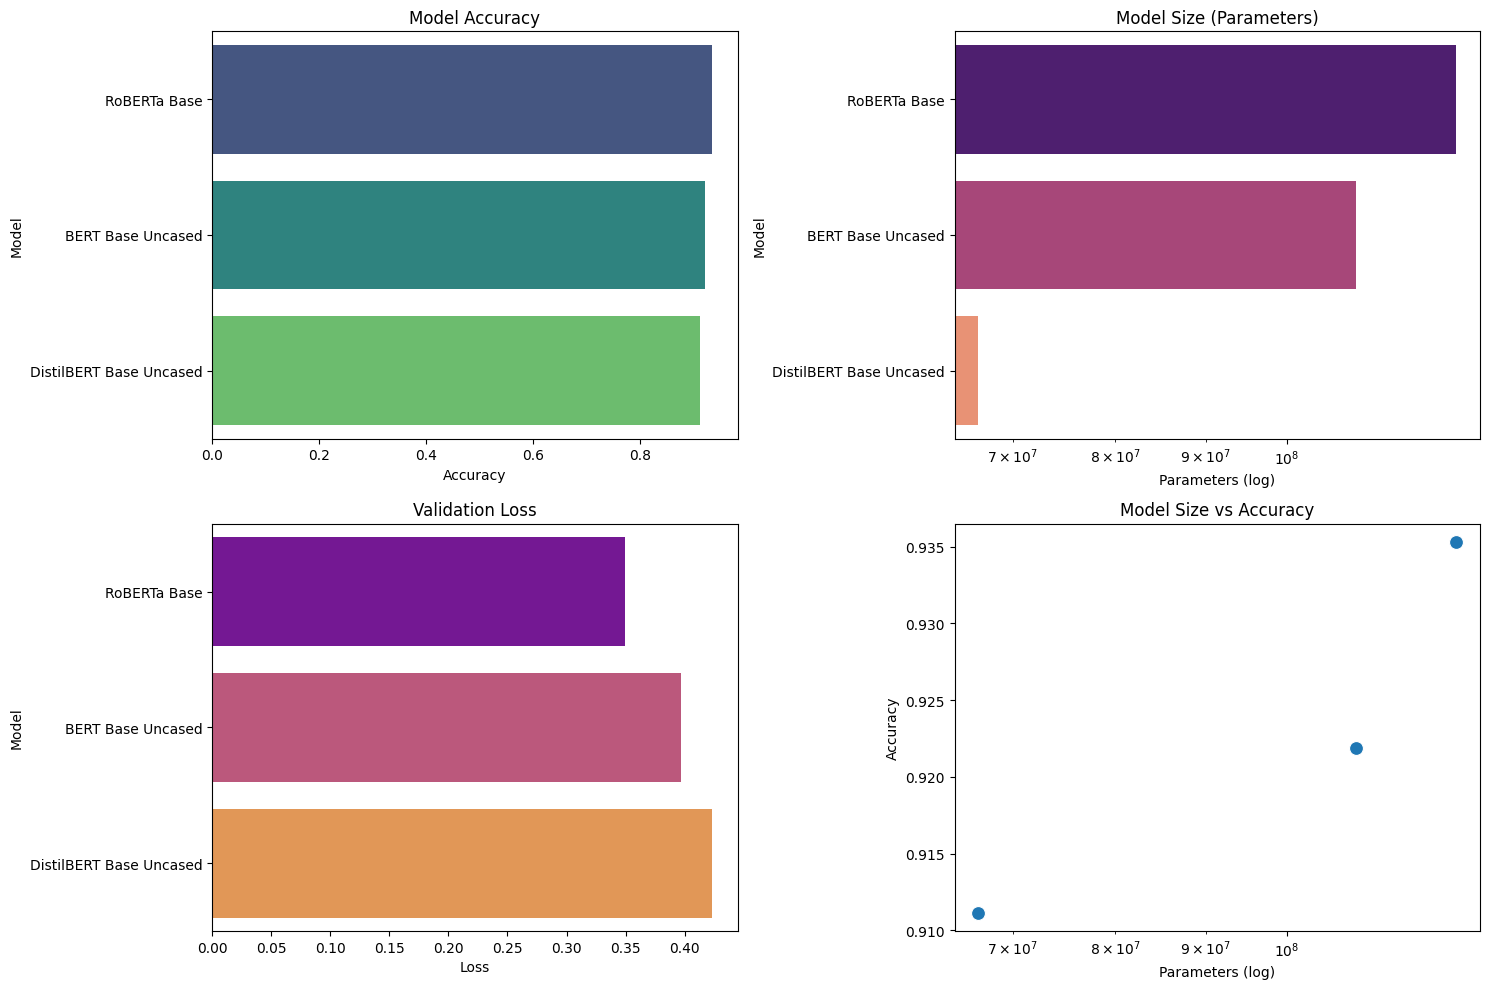


Done. Best models (model-only) live at: .../models/<model_id_sanitized>/best_model/
These are ready to load for your Sentihood aspect analysis.


In [ ]:
results_df = pd.DataFrame.from_dict(results, orient='index').sort_values('eval_accuracy', ascending=False)
results_df.to_csv(os.path.join(COMPARISON_DIR, 'model_comparison_results.csv'))

print("\n=== MODEL PERFORMANCE COMPARISON ===")
print(results_df[["model_name", "eval_accuracy", "eval_f1_weighted", "eval_loss", "model_size"]])

plt.figure(figsize=(15, 10))

# (1) Accuracy by model
plt.subplot(2, 2, 1)
sns.barplot(x='eval_accuracy', y='model_name', data=results_df.reset_index(), palette='viridis')
plt.title('Model Accuracy'); plt.xlabel('Accuracy'); plt.ylabel('Model')

# (2) Model size (log scale)
plt.subplot(2, 2, 2)
sns.barplot(x='model_size', y='model_name', data=results_df.reset_index(), palette='magma')
plt.title('Model Size (Parameters)'); plt.xlabel('Parameters (log)'); plt.ylabel('Model')
plt.xscale('log')

# (3) Validation loss
plt.subplot(2, 2, 3)
sns.barplot(x='eval_loss', y='model_name', data=results_df.reset_index(), palette='plasma')
plt.title('Validation Loss'); plt.xlabel('Loss'); plt.ylabel('Model')

# (4) Size vs Accuracy (scatter)
plt.subplot(2, 2, 4)
sns.scatterplot(x='model_size', y='eval_accuracy', data=results_df, s=100)
plt.title('Model Size vs Accuracy'); plt.xlabel('Parameters (log)'); plt.ylabel('Accuracy')
plt.xscale('log')

plt.tight_layout()
plt.savefig(os.path.join(COMPARISON_DIR, 'model_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\nDone. Best models (model-only) live at: .../models/<model_id_sanitized>/best_model/")
print("These are ready to load for your Sentihood aspect analysis.")

<h1> <strong> Try the saved model on new examples (not from train/test) </strong> </h1>
<p> Below is a self-contained inference cell.
It loads one of the saved best_model/ folders and runs predictions on custom sentences.</p>

In [ ]:
# ==== Inference on custom (new) examples ====
import torch, os
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 1) Point to one saved best model (pick any backbone you trained)
BEST_DIR = "/content/drive/MyDrive/bert_imdb_sentiment_analysis/models/bert-base-uncased/best_model"
assert os.path.isdir(BEST_DIR), "Update BEST_DIR to a valid best_model folder."

# 2) Load tokenizer + model (no training needed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(BEST_DIR, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(BEST_DIR).to(device)
model.eval()

# 3) Label map (matches training: 0=NEGATIVE, 1=POSITIVE)
id2label = {0: "NEGATIVE", 1: "POSITIVE"}

# 4) New examples (not from IMDb splits — just handmade sentences)
examples = [
    "What a breathtaking film! The performances were incredibly moving and the score was beautiful.",
    "I fell asleep twice. The plot made no sense and the pacing was painfully slow.",
    "Surprisingly decent. It’s not perfect but I didn’t regret watching it.",
    "The script is sharp and funny; I laughed more than I expected.",
    "Overhyped and shallow. Gorgeous visuals can’t hide the weak story.",
    "It starts rough, but the last 30 minutes are fantastic and totally worth it.",
    "The villain was cartoonish and the dialogue was cringey.",
    "Heartwarming, with characters I genuinely cared about.",
    "Mediocre at best. I wouldn’t recommend it, but it’s okay for a rainy day.",
    "An instant classic—I can’t wait to rewatch it with friends.",
]

# 5) Predict helper
@torch.no_grad()
def predict(texts, batch_size=8, max_length=256):
    outputs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(
            batch, return_tensors="pt", truncation=True, padding=True,
            max_length=max_length
        ).to(device)
        logits = model(**enc).logits
        probs = torch.softmax(logits, dim=-1)
        pred_ids = probs.argmax(dim=-1).tolist()

        for j, t in enumerate(batch):
            outputs.append({
                "text": t,
                "label_id": int(pred_ids[j]),
                "label": id2label[int(pred_ids[j])],
                "confidence": float(probs[j, pred_ids[j]].item())
            })
    return outputs

# Run predictions
preds = predict(examples)
for p in preds:
    print(f"[{p['label']:<8}] {p['confidence']:.3f}  |  {p['text']}")

[POSITIVE] 1.000  |  What a breathtaking film! The performances were incredibly moving and the score was beautiful.
[NEGATIVE] 0.999  |  I fell asleep twice. The plot made no sense and the pacing was painfully slow.
[POSITIVE] 0.998  |  Surprisingly decent. It’s not perfect but I didn’t regret watching it.
[POSITIVE] 1.000  |  The script is sharp and funny; I laughed more than I expected.
[NEGATIVE] 0.998  |  Overhyped and shallow. Gorgeous visuals can’t hide the weak story.
[POSITIVE] 1.000  |  It starts rough, but the last 30 minutes are fantastic and totally worth it.
[NEGATIVE] 0.999  |  The villain was cartoonish and the dialogue was cringey.
[POSITIVE] 1.000  |  Heartwarming, with characters I genuinely cared about.
[NEGATIVE] 0.994  |  Mediocre at best. I wouldn’t recommend it, but it’s okay for a rainy day.
[POSITIVE] 0.999  |  An instant classic—I can’t wait to rewatch it with friends.
